<a href="https://colab.research.google.com/github/VCKarthik/SuperStoreData/blob/main/SuperStore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import sqlite3
from sqlite3 import Error
import os

def create_connection(db_file, delete_db=False):
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

def create_table(conn, create_table_sql, drop_table_name=None):
    if drop_table_name:
        try:
            c = conn.cursor()
            c.execute(f"DROP TABLE IF EXISTS {drop_table_name}")
        except Error as e:
            print(e)

    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

In [20]:
def step1_create_customer_table(data_filename, normalized_database_filename):
    customer_set = set()
    with open(data_filename,encoding='ISO-8859-1') as file:
        header = None
        for line in file:
            if not line.strip():
                continue
            if not header:
                header = line.strip().split(",")
                continue
            data = line.strip().split(",")
            customer = (data[5], data[6], data[7])
            customer_set.add(customer)

    customers = sorted(customer_set, key=lambda ele: ele[0])

    create_customer_table_sql = """
    CREATE TABLE Customer(
        CustomerID TEXT PRIMARY KEY,
        CustomerName TEXT NOT NULL,
        Segment TEXT NOT NULL
    );
    """

    def insert_customer(conn, values):
        sql = "INSERT INTO Customer (CustomerID, CustomerName, Segment) VALUES (?, ?, ?)"
        cur = conn.cursor()
        cur.executemany(sql, values)
        return cur.lastrowid

    conn = create_connection(normalized_database_filename, True)
    with conn:
        create_table(conn, create_customer_table_sql, "Customer")
        insert_customer(conn, customers)
    conn.close()

In [21]:
step1_create_customer_table("/content/Sample - Superstore.csv", "example.db")
conn = sqlite3.connect("example.db")
df = pd.read_sql_query("select * from Customer", conn)

display(df)
conn.close()

,CustomerID,CustomerName,Segment
0,AA-10315,Alex Avila,Consumer
1,AA-10375,Allen Armold,Consumer
2,AA-10480,Andrew Allen,Consumer
3,AA-10645,Anna Andreadi,Consumer
4,AB-10015,Aaron Bergman,Consumer
...,...,...,...
788,XP-21865,Xylona Preis,Consumer
789,YC-21895,Yoseph Carroll,Corporate
790,YS-21880,Yana Sorensen,Corporate
791,ZC-21910,Zuschuss Carroll,Consumer


In [22]:
def step2_create_category_subcategory_tables(data_filename, normalized_database_filename):
    subcategory_set = set()
    with open(data_filename, encoding="ISO-8859-1") as file:
        header = None
        for line in file:
            if not line.strip():
                continue
            if not header:
                header = line.strip().split(",")
                continue
            data = line.strip().split(",")
            subcategory = (data[15].strip(), data[14].strip())  # SubCategory, Category
            subcategory_set.add(subcategory)

    subcategories = sorted(list(subcategory_set), key=lambda ele: ele[0])
    category_set = set((subcat[1],) for subcat in subcategories)
    categories = sorted(list(category_set), key=lambda ele: ele[0])

    category_dict = {val[0]: idx + 1 for idx, val in enumerate(categories)}
    subcategories_with_ids = [
        (idx + 1, subcat[0], category_dict[subcat[1]])
        for idx, subcat in enumerate(subcategories)
    ]

    product_set = set()
    with open(data_filename, encoding="ISO-8859-1") as file:
        header = None
        for line in file:
            if not line.strip():
                continue
            if not header:
                header = line.strip().split(",")
                continue
            data = line.strip().split(",")
            product = (data[13].strip(), data[16].strip(), data[15].strip())  # ProductID, ProductName, SubCategory
            product_set.add(product)

    subcat_dict = {val[1]: val[0] for val in subcategories_with_ids}

    temp_products = [
        (prod[0], prod[1], subcat_dict[prod[2]])
        for prod in product_set if prod[2] in subcat_dict
    ]

    seen = set()
    products = []
    for p in temp_products:
        if p[0] not in seen:
            products.append(p)
            seen.add(p[0])

    create_category_table_sql = """
    CREATE TABLE Category(
        CategoryID INTEGER PRIMARY KEY,
        Category TEXT NOT NULL
    );
    """

    create_subcategory_table_sql = """
    CREATE TABLE SubCategory(
        SubCategoryID INTEGER PRIMARY KEY,
        SubCategory TEXT NOT NULL,
        CategoryID INTEGER NOT NULL,
        FOREIGN KEY (CategoryID) REFERENCES Category(CategoryID)
    );
    """

    create_product_table_sql = """
    CREATE TABLE Product(
        ProductID TEXT PRIMARY KEY,
        ProductName TEXT NOT NULL,
        SubCategoryID INTEGER NOT NULL,
        FOREIGN KEY (SubCategoryID) REFERENCES SubCategory(SubCategoryID)
    );
    """

    def insert_category(conn, values):
        sql = "INSERT INTO Category (Category) VALUES (?)"
        cur = conn.cursor()
        cur.executemany(sql, values)
        return cur.lastrowid

    def insert_subcategory(conn, values):
        sql = "INSERT INTO SubCategory (SubCategoryID, SubCategory, CategoryID) VALUES (?, ?, ?)"
        cur = conn.cursor()
        cur.executemany(sql, values)
        return cur.lastrowid

    def insert_product(conn, values):
        sql = "INSERT INTO Product (ProductID, ProductName, SubCategoryID) VALUES (?, ?, ?)"
        cur = conn.cursor()
        cur.executemany(sql, values)
        return cur.lastrowid

    conn = create_connection(normalized_database_filename)
    with conn:
        create_table(conn,create_category_table_sql, "Category")
        create_table(conn,create_subcategory_table_sql, "SubCategory")
        create_table(conn,create_product_table_sql, "Product")
        insert_category(conn, categories)
        insert_subcategory(conn, subcategories_with_ids)
        insert_product(conn, products)
    conn.close()


In [23]:
step2_create_category_subcategory_tables("/content/Sample - Superstore.csv", "example.db")
conn = sqlite3.connect("example.db")
df = pd.read_sql_query("select * from Category", conn)
df1 = pd.read_sql_query("select * from SubCategory", conn)
df2 = pd.read_sql_query("select * from Product", conn)
display(df)
display(df1)
display(df2)
conn.close()

,CategoryID,Category
0,1,Furniture
1,2,Office Supplies
2,3,Technology


,SubCategoryID,SubCategory,CategoryID
0,1,Accessories,3
1,2,Appliances,2
2,3,Art,2
3,4,Binders,2
4,5,Bookcases,1
5,6,Chairs,1
6,7,Copiers,3
7,8,Envelopes,2
8,9,Fasteners,2
9,10,Furnishings,1


,ProductID,ProductName,SubCategoryID
0,FUR-TA-10004152,"""Barricks 18"""" x 48"""" Non-Folding Utility Tabl...",17
1,OFF-EN-10002504,"""Tyvek Top-Opening Peel & Seel Envelopes",8
2,OFF-ST-10000615,"""SimpliFile Personal File",15
3,OFF-AP-10001058,Sanyo 2.5 Cubic Foot Mid-Size Office Refrigera...,2
4,OFF-PA-10001752,Hammermill CopyPlus Copy Paper (20Lb. and 84 B...,13
...,...,...,...
1857,TEC-PH-10002085,Clarity 53712,14
1858,OFF-AR-10002257,"""Eldon Spacemaker Box",3
1859,FUR-CH-10002024,HON 5400 Series Task Chairs for Big and Tall,6
1860,OFF-LA-10004425,Staple-on labels,11


In [24]:
def step3_create_location_table(data_filename, normalized_database_filename):
    region_set = set()
    state_set = set()
    city_set = set()
    postal_set = set()

    with open(data_filename, encoding="ISO-8859-1") as file:
        header = None
        for line in file:
            if not line.strip():
                continue
            if not header:
                header = line.strip().split(",")
                continue
            data = line.strip().split(",")

            # Correct column indices
            country = data[8].strip()
            city = data[9].strip()
            state = data[10].strip()
            postal = data[11].strip()
            region = data[12].strip()

            region_set.add((region, country))
            state_set.add((state, region))
            city_set.add((city, state, region))
            postal_set.add((postal, city, state, region))

    # Region with Country
    regions = sorted(list(region_set))
    region_map = {region: idx + 1 for idx, (region, _) in enumerate(regions)}
    regions = [(region_map[region], region, country) for region, country in region_set]

    # State
    states = sorted(list(state_set))
    state_map = {state: idx + 1 for idx, (state, _) in enumerate(states)}
    states = [(state_map[state], state, region_map[region]) for state, region in state_set]

    # City
    cities_raw = sorted(list(city_set))
    city_map = {
        (city, state, region): idx + 1
        for idx, (city, state, region) in enumerate(cities_raw)
    }
    cities = [
        (city_map[(city, state, region)], city, state_map[state])
        for city, state, region in cities_raw
    ]

    # Location
    locations_raw = sorted(list(postal_set))
    locations = [
        (idx + 1, postal, city_map[(city, state, region)])
        for idx, (postal, city, state, region) in enumerate(locations_raw)
    ]

    conn = create_connection(normalized_database_filename)
    with conn:
        create_table(conn, """
            CREATE TABLE Region (
                RegionID INTEGER PRIMARY KEY,
                Region TEXT NOT NULL,
                Country TEXT NOT NULL
            );
        """, "Region")
        create_table(conn, """
            CREATE TABLE State (
                StateID INTEGER PRIMARY KEY,
                State TEXT NOT NULL,
                RegionID INTEGER NOT NULL,
                FOREIGN KEY (RegionID) REFERENCES Region(RegionID)
            );
        """, "State")
        create_table(conn, """
            CREATE TABLE City (
                CityID INTEGER PRIMARY KEY,
                City TEXT NOT NULL,
                StateID INTEGER NOT NULL,
                FOREIGN KEY (StateID) REFERENCES State(StateID)
            );
        """, "City")
        create_table(conn, """
            CREATE TABLE Location (
                LocationID INTEGER PRIMARY KEY,
                PostalCode TEXT NOT NULL,
                CityID INTEGER NOT NULL,
                FOREIGN KEY (CityID) REFERENCES City(CityID)
            );
        """, "Location")

        conn.executemany("INSERT INTO Region (RegionID, Region, Country) VALUES (?, ?, ?)", regions)
        conn.executemany("INSERT INTO State (StateID, State, RegionID) VALUES (?, ?, ?)", states)
        conn.executemany("INSERT INTO City (CityID, City, StateID) VALUES (?, ?, ?)", cities)
        conn.executemany("INSERT INTO Location (LocationID, PostalCode, CityID) VALUES (?, ?, ?)", locations)
    conn.close()


In [25]:
step3_create_location_table("/content/Sample - Superstore.csv", "example.db")
conn = sqlite3.connect("example.db")

df1 = pd.read_sql_query("select * from Region", conn)
df2 = pd.read_sql_query("select * from State", conn)
df3 = pd.read_sql_query("select * from City", conn)
df4 = pd.read_sql_query("select * from Location", conn)

display(df1)
display(df2)
display(df3)
display(df4)
conn.close()

,RegionID,Region,Country
0,1,Central,United States
1,2,East,United States
2,3,South,United States
3,4,West,United States


,StateID,State,RegionID
0,1,Alabama,3
1,2,Arizona,4
2,3,Arkansas,3
3,4,California,4
4,5,Colorado,4
5,6,Connecticut,2
6,7,Delaware,2
7,8,District of Columbia,2
8,9,Florida,3
9,10,Georgia,3


,CityID,City,StateID
0,1,Aberdeen,40
1,2,Abilene,42
2,3,Akron,34
3,4,Albuquerque,30
4,5,Alexandria,45
...,...,...,...
599,600,Woonsocket,38
600,601,Yonkers,31
601,602,York,37
602,603,Yucaipa,4


,LocationID,PostalCode,CityID
0,1,05408,71
1,2,10009,381
2,3,10011,381
3,4,10024,381
4,5,10035,381
...,...,...,...
627,628,98502,402
628,629,98632,311
629,630,98661,569
630,631,99207,529


In [26]:
def step4_create_order_table(data_filename, normalized_database_filename):
    order_set = set()
    location_map = {}
    location_id = 1

    with open(data_filename, encoding="ISO-8859-1") as file:
        header = None
        for line in file:
            if not line.strip():
                continue
            if not header:
                header = line.strip().split(",")
                continue
            data = line.strip().split(",")

            # ✅ Corrected location components:
            city = data[9].strip()
            state = data[10].strip()
            region = data[12].strip()
            postal = data[11].strip()
            location = (city, state, region, postal)

            # Assign location ID
            if location not in location_map:
                location_map[location] = location_id
                location_id += 1

            # ✅ Corrected order tuple with CustomerID (index 5)
            order = (
                data[1].strip(),  # Order ID
                data[2].strip(),  # Order Date
                data[3].strip(),  # Ship Date
                data[4].strip(),  # Ship Mode
                data[5].strip(),  # Customer ID
                location_map[location]  # Location ID
            )
            order_set.add(order)

    orders = sorted(list(order_set), key=lambda ele: ele[0])

    create_order_table_sql = """
    CREATE TABLE OrderTable(
        OrderID TEXT PRIMARY KEY,
        OrderDate TEXT NOT NULL,
        ShipDate TEXT NOT NULL,
        ShipMode TEXT NOT NULL,
        CustomerID TEXT NOT NULL,
        LocationID INTEGER NOT NULL,
        FOREIGN KEY (CustomerID) REFERENCES Customer(CustomerID),
        FOREIGN KEY (LocationID) REFERENCES Location(LocationID)
    );
    """

    def insert_orders(conn, values):
        sql = """
        INSERT INTO OrderTable (
            OrderID, OrderDate, ShipDate, ShipMode, CustomerID, LocationID
        ) VALUES (?, ?, ?, ?, ?, ?)
        """
        cur = conn.cursor()
        cur.executemany(sql, values)
        return cur.lastrowid

    conn = create_connection(normalized_database_filename)
    with conn:
        create_table(conn, create_order_table_sql,"OrderTable")
        insert_orders(conn, orders)
    conn.close()


In [27]:
step4_create_order_table("/content/Sample - Superstore.csv", "example.db")
conn = sqlite3.connect("example.db")
df = pd.read_sql_query("select * from OrderTable", conn)

display(df)
conn.close()

,OrderID,OrderDate,ShipDate,ShipMode,CustomerID,LocationID
0,CA-2014-100006,9/7/2014,9/13/2014,Standard Class,DK-13375,24
1,CA-2014-100090,7/8/2014,7/12/2014,Standard Class,EB-13705,35
2,CA-2014-100293,3/14/2014,3/18/2014,Standard Class,NF-18475,134
3,CA-2014-100328,1/28/2014,2/3/2014,Standard Class,JC-15340,24
4,CA-2014-100363,4/8/2014,4/15/2014,Standard Class,JM-15655,277
...,...,...,...,...,...,...
5004,US-2017-168802,11/3/2017,11/7/2017,Standard Class,JO-15145,6
5005,US-2017-169320,7/23/2017,7/25/2017,Second Class,LH-16900,492
5006,US-2017-169488,9/7/2017,9/9/2017,First Class,AA-10375,260
5007,US-2017-169502,8/28/2017,9/1/2017,Standard Class,MG-17650,202


In [28]:
import csv

def step5_create_order_detail_table(data_filename, normalized_database_filename):
    detail_set = set()

    with open(data_filename, encoding="ISO-8859-1") as file:
        reader = csv.reader(file)
        header = next(reader)  # Skip the header row

        for data in reader:
            if not data or len(data) < 21:
                continue  # Skip empty or malformed rows

            try:
                row_id = int(data[0].strip())         # Row ID
                order_id = data[1].strip()            # Order ID
                product_id = data[13].strip()         # Product ID
                sales = float(data[17])               # Sales
                quantity = int(data[18])              # Quantity
                discount = float(data[19])            # Discount
                profit = float(data[20])              # Profit

                detail = (row_id, order_id, product_id, sales, quantity, discount, profit)
                detail_set.add(detail)

            except (ValueError, IndexError):
                # Skip rows with invalid numbers or missing data
                continue

    order_details = sorted(list(detail_set), key=lambda ele: ele[0])

    create_order_detail_table_sql = """
    CREATE TABLE OrderDetail(
        RowID INTEGER PRIMARY KEY,
        OrderID TEXT NOT NULL,
        ProductID TEXT NOT NULL,
        Sales REAL,
        Quantity INTEGER,
        Discount REAL,
        Profit REAL,
        FOREIGN KEY (OrderID) REFERENCES OrderTable(OrderID),
        FOREIGN KEY (ProductID) REFERENCES Product(ProductID)
    );
    """

    def insert_order_details(conn, values):
        sql = """
        INSERT INTO OrderDetail (
            RowID, OrderID, ProductID, Sales, Quantity, Discount, Profit
        ) VALUES (?, ?, ?, ?, ?, ?, ?)
        """
        cur = conn.cursor()
        cur.executemany(sql, values)
        return cur.lastrowid

    conn = create_connection(normalized_database_filename)
    with conn:
        create_table(conn, create_order_detail_table_sql, "OrderDetail")
        insert_order_details(conn, order_details)
    conn.close()


In [29]:
step5_create_order_detail_table("/content/Sample - Superstore.csv", "example.db")
conn = sqlite3.connect("example.db")
df = pd.read_sql_query("select * from OrderDetail", conn)

display(df)
conn.close()

,RowID,OrderID,ProductID,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,FUR-BO-10001798,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,FUR-CH-10000454,731.9400,3,0.00,219.5820
2,3,CA-2016-138688,OFF-LA-10000240,14.6200,2,0.00,6.8714
3,4,US-2015-108966,FUR-TA-10000577,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,OFF-ST-10000760,22.3680,2,0.20,2.5164
...,...,...,...,...,...,...,...
9989,9990,CA-2014-110422,FUR-FU-10001889,25.2480,3,0.20,4.1028
9990,9991,CA-2017-121258,FUR-FU-10000747,91.9600,2,0.00,15.6332
9991,9992,CA-2017-121258,TEC-PH-10003645,258.5760,2,0.20,19.3932
9992,9993,CA-2017-121258,OFF-PA-10004041,29.6000,4,0.00,13.3200


In [30]:
conn = sqlite3.connect("/content/example.db")



queries = {
    "1. Year-on-Year Sales (SQL)": """
    SELECT
        substr(OrderDate, -4) AS Year,
        ROUND(SUM(Sales), 2) AS TotalSales
    FROM OrderDetail od
    JOIN OrderTable o ON od.OrderID = o.OrderID
    GROUP BY Year
    ORDER BY Year;
    """,
    "2. Most Profitable Customer Segments (SQL)": """
        SELECT c.Segment, ROUND(SUM(od.Profit), 2) AS TotalProfit
        FROM OrderDetail od
        JOIN OrderTable o ON od.OrderID = o.OrderID
        JOIN Customer c ON o.CustomerID = c.CustomerID
        GROUP BY c.Segment
        ORDER BY TotalProfit DESC;
    """,
    "3. Underperforming Subcategories (SQL)": """
        SELECT
            s.SubCategory,
            ROUND(SUM(od.Profit), 2) AS TotalProfit
        FROM OrderDetail od
        JOIN Product p ON od.ProductID = p.ProductID
        JOIN SubCategory s ON p.SubCategoryID = s.SubCategoryID
        GROUP BY s.SubCategory
        HAVING TotalProfit < 0;
    """,
    "4. Region-wise Sales (SQL)": """
        SELECT
            r.Region,
            ROUND(SUM(od.Sales), 2) AS TotalSales
        FROM OrderDetail od
        JOIN OrderTable o ON od.OrderID = o.OrderID
        JOIN Location l ON o.LocationID = l.LocationID
        JOIN City ci ON l.CityID = ci.CityID
        JOIN State st ON ci.StateID = st.StateID
        JOIN Region r ON st.RegionID = r.RegionID
        GROUP BY r.Region
        ORDER BY TotalSales DESC;
    """,
    "5. Top-Selling Product (SQL)": """
        SELECT
            p.ProductName,
            SUM(od.Quantity) AS TotalQuantity
        FROM OrderDetail od
        JOIN Product p ON od.ProductID = p.ProductID
        GROUP BY p.ProductName
        ORDER BY TotalQuantity DESC
        LIMIT 1;
    """
}

results = {k: pd.read_sql_query(v, conn) for k, v in queries.items()}
from IPython.display import display

# Display each SQL result individually
for title, df in results.items():
    print(f"\n🔹 {title}")
    display(df)



🔹 1. Year-on-Year Sales (SQL)


,Year,TotalSales
0,2014,484247.50
1,2015,470532.51
2,2016,609205.60
3,2017,733215.26



🔹 2. Most Profitable Customer Segments (SQL)


,Segment,TotalProfit
0,Consumer,134119.21
1,Corporate,91979.13
2,Home Office,60298.68



🔹 3. Underperforming Subcategories (SQL)


,SubCategory,TotalProfit
0,Bookcases,-3472.56
1,Supplies,-1189.10
2,Tables,-17725.48



🔹 4. Region-wise Sales (SQL)


,Region,TotalSales
0,East,907217.95
1,South,875013.35
2,Central,392973.63
3,West,121995.93



🔹 5. Top-Selling Product (SQL)


,ProductName,TotalQuantity
0,Staples,215


from matplotlib import pyplot as plt
_df_12['TotalSales'].plot(kind='hist', bins=20, title='TotalSales')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_13.groupby('Year').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series['TotalSales']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('Year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Year')):
  _plot_series(series, series_name, i)
  fig.legend(title='Year', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('TotalSales')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Year']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Year'}, axis=1)
              .sort_values('Year', ascending=True))
  xs = counted['Year']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('Year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Year')):
  _plot_series(series, series_name, i)
  fig.legend(title='Year', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_16['TotalSales'].plot(kind='line', figsize=(8, 4), title='TotalSales')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Year'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='TotalSales', y='Year', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
_df_18['TotalProfit'].plot(kind='hist', bins=20, title='TotalProfit')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_19.groupby('Segment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20['TotalProfit'].plot(kind='line', figsize=(8, 4), title='TotalProfit')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['Segment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='TotalProfit', y='Segment', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
_df_22['TotalProfit'].plot(kind='hist', bins=20, title='TotalProfit')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_23.groupby('SubCategory').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_24['TotalProfit'].plot(kind='line', figsize=(8, 4), title='TotalProfit')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_25['SubCategory'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_25, x='TotalProfit', y='SubCategory', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
_df_26['TotalSales'].plot(kind='hist', bins=20, title='TotalSales')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_27.groupby('Region').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_28['TotalSales'].plot(kind='line', figsize=(8, 4), title='TotalSales')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_29['Region'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_29, x='TotalSales', y='Region', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [14]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Connect to the rebuilt database
conn = sqlite3.connect("/content/example.db")

# Load all necessary tables into pandas DataFrames
order_df = pd.read_sql_query("SELECT * FROM OrderTable", conn)
detail_df = pd.read_sql_query("SELECT * FROM OrderDetail", conn)
product_df = pd.read_sql_query("SELECT * FROM Product", conn)
subcat_df = pd.read_sql_query("SELECT * FROM SubCategory", conn)
cat_df = pd.read_sql_query("SELECT * FROM Category", conn)
location_df = pd.read_sql_query("SELECT * FROM Location", conn)
city_df = pd.read_sql_query("SELECT * FROM City", conn)
state_df = pd.read_sql_query("SELECT * FROM State", conn)
region_df = pd.read_sql_query("SELECT * FROM Region", conn)
customer_df = pd.read_sql_query("SELECT * FROM Customer", conn)

# 1. Year-on-Year Sales
order_detail = detail_df.merge(order_df, on="OrderID")
order_detail['Year'] = pd.to_datetime(order_detail['OrderDate']).dt.year
q1_pandas = order_detail.groupby('Year')['Sales'].sum().round(2).reset_index()

# 2. Most Profitable Customer Segments
order_customer = detail_df.merge(order_df, on="OrderID").merge(customer_df, on="CustomerID")
q2_pandas = order_customer.groupby('Segment')['Profit'].sum().round(2).reset_index().sort_values(by='Profit', ascending=False)

# 3. Underperforming Subcategories
cat_joined = detail_df.merge(product_df, on="ProductID") \
                      .merge(subcat_df, on="SubCategoryID")
subcat_profit = cat_joined.groupby('SubCategory')['Profit'].sum().reset_index()
q3_pandas = subcat_profit[subcat_profit['Profit'] < 0].round(2)

# 4. Region-wise Sales
loc_joined = order_df.merge(location_df, on="LocationID") \
                     .merge(city_df, on="CityID") \
                     .merge(state_df, on="StateID") \
                     .merge(region_df, on="RegionID")
order_region = detail_df.merge(loc_joined[['OrderID', 'Region']], on="OrderID")
q4_pandas = order_region.groupby('Region')['Sales'].sum().sort_values(ascending=False).round(2).reset_index()

# 5. Top-Selling Product by Quantity
top_product = detail_df.merge(product_df, on="ProductID")
q5_pandas = top_product.groupby('ProductName')['Quantity'].sum().sort_values(ascending=False).reset_index().head(1)

In [15]:
from IPython.display import display

print("1. Year-on-Year Sales")
display(q1_pandas)

print("\n2. Most Profitable Customer Segments ")
display(q2_pandas)

print("\n3. Negative Profit Subcategories")
display(q3_pandas)

print("\n4. Region Sales")
display(q4_pandas)

print("\n5. Top Product by Quantity")
display(q5_pandas)


1. Year-on-Year Sales


,Year,Sales
0,2014,484247.50
1,2015,470532.51
2,2016,609205.60
3,2017,733215.26



2. Most Profitable Customer Segments 


,Segment,Profit
0,Consumer,134119.21
1,Corporate,91979.13
2,Home Office,60298.68



3. Negative Profit Subcategories


,SubCategory,Profit
4,Bookcases,-3472.56
15,Supplies,-1189.10
16,Tables,-17725.48



4. Region Sales


,Region,Sales
0,East,907217.95
1,South,875013.35
2,Central,392973.63
3,West,121995.93



5. Top Product by Quantity


,ProductName,Quantity
0,Staples,215


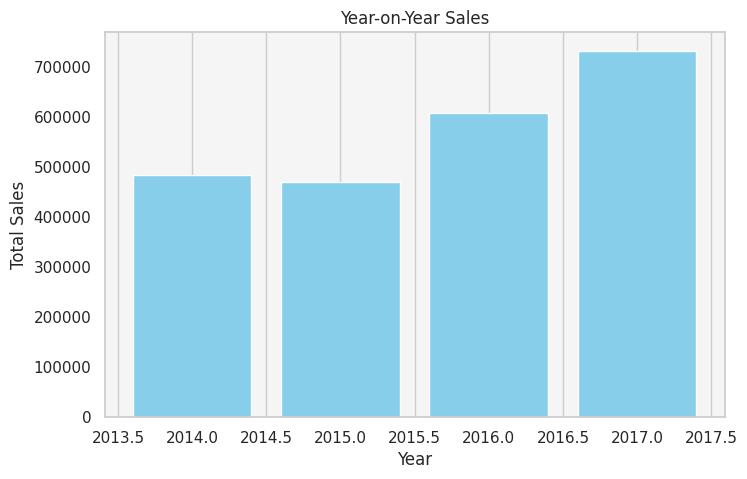

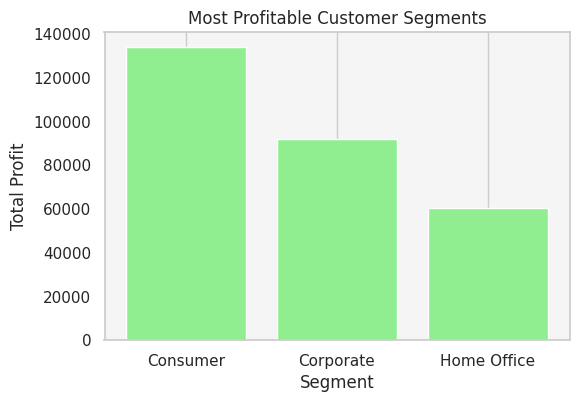

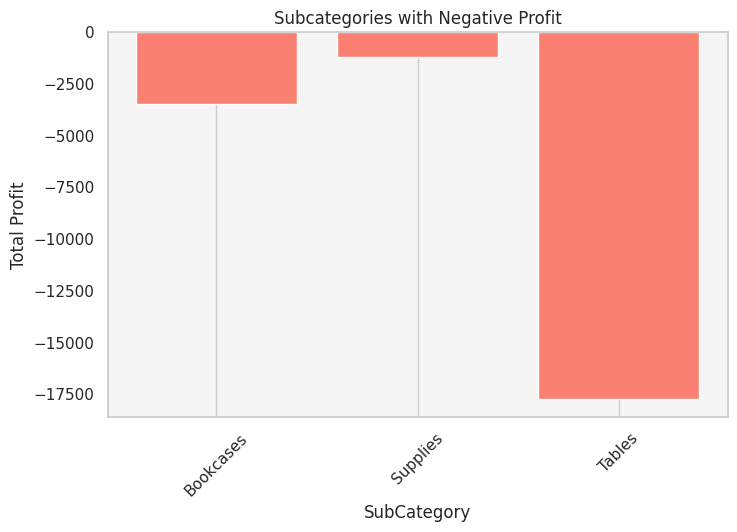

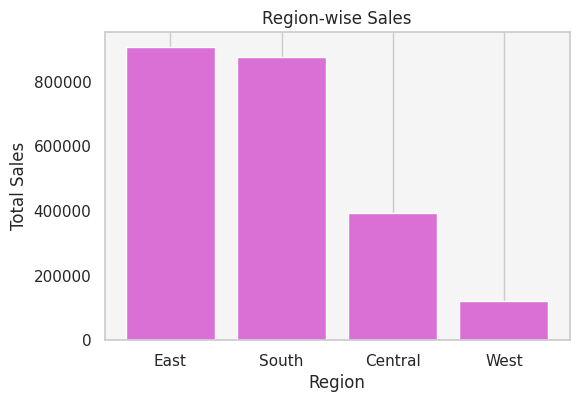

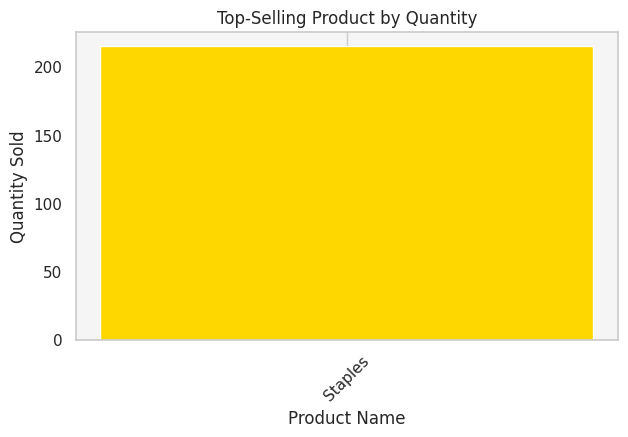

In [29]:
# Visualization 1: Year-on-Year Sales
plt.figure(figsize=(8, 5))
plt.bar(q1_pandas['Year'], q1_pandas['Sales'], color='skyblue')
plt.title("Year-on-Year Sales")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.grid(axis='y')
plt.show()
print('\n')

# Visualization 2: Most Profitable Customer Segments
plt.figure(figsize=(6, 4))
plt.bar(q2_pandas['Segment'], q2_pandas['Profit'], color='lightgreen')
plt.title("Most Profitable Customer Segments")
plt.xlabel("Segment")
plt.ylabel("Total Profit")
plt.grid(axis='y')
plt.show()
print('\n')

# Visualization 3: Underperforming Subcategories
plt.figure(figsize=(8, 5))
plt.bar(q3_pandas['SubCategory'], q3_pandas['Profit'], color='salmon')
plt.title("Subcategories with Negative Profit")
plt.xlabel("SubCategory")
plt.ylabel("Total Profit")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()
print('\n')

# Visualization 4: Region-wise Sales
plt.figure(figsize=(6, 4))
plt.bar(q4_pandas['Region'], q4_pandas['Sales'], color='orchid')
plt.title("Region-wise Sales")
plt.xlabel("Region")
plt.ylabel("Total Sales")
plt.grid(axis='y')
plt.show()
print('\n')

# Visualization 5: Top-Selling Product
plt.figure(figsize=(7, 4))
plt.bar(q5_pandas['ProductName'], q5_pandas['Quantity'], color='gold')
plt.title("Top-Selling Product by Quantity")
plt.xlabel("Product Name")
plt.ylabel("Quantity Sold")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()
print('\n')